In [1]:
import os
import numpy as np
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler 
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.cuda.empty_cache()

In [4]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

def data_loader(
    train_dir=None,
    valid_dir=None,
    batch_size=64,
    random_seed=42,
    shuffle=True,
    test=False
):
    # Transformaciones para el conjunto de datos
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.ToTensor(),
        transforms.Normalize([0.0208, 0.0202, 0.0191], [0.0091, 0.0091, 0.0098])
    ])
    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0208, 0.0202, 0.0191], [0.0091, 0.0091, 0.0098])
    ])

    if test:
        dataset = datasets.ImageFolder(
            root=train_dir, transform=transform_val
        )
        data_loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )
        return data_loader

    # Cargar datos de entrenamiento
    train_loader = None
    if train_dir:
        train_dataset = datasets.ImageFolder(
            root=train_dir, transform=transform_train
        )
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle
        )

    # Cargar datos de validación
    valid_loader = None
    if valid_dir:
        valid_dataset = datasets.ImageFolder(
            root=valid_dir, transform=transform_val
        )
        valid_loader = DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=shuffle
        )

    return train_loader, valid_loader


# Rutas de tus datasets
train_dir = 'C:/Users/cesar/Downloads/garbage-dataset_balanceado'
valid_dir = 'C:/Users/cesar/Downloads/dataset_prueba_final'

# Llamar a la función
train_loader, valid_loader = data_loader(
    train_dir=train_dir,
    valid_dir=valid_dir,
    batch_size=64
)


In [5]:
# Definición del bloque residual
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [6]:
# Redefinir la arquitectura de ResNet50
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):  # Cambia el num_classes según tus datos
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [7]:
# Número de clases según tu dataset
num_classes = len(os.listdir(train_dir))  # Esto obtiene el número de carpetas (clases)
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [8]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

# Variables para almacenar el accuracy y loss de entrenamiento y validación
train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []
# Entrenamiento
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Entrenamiento por lotes
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        # Calculando precisión de entrenamiento
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    # Validación
    model.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculando precisión de validación
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            running_loss_valid += loss.item()

    valid_loss = running_loss_valid / len(valid_loader)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

Epoch [1/20], Train Loss: 1.3367, Train Accuracy: 46.34%, Validation Loss: 1.1804, Validation Accuracy: 52.00%
Epoch [2/20], Train Loss: 1.0967, Train Accuracy: 57.30%, Validation Loss: 1.1792, Validation Accuracy: 56.00%
Epoch [3/20], Train Loss: 0.9726, Train Accuracy: 61.91%, Validation Loss: 1.0461, Validation Accuracy: 54.00%
Epoch [4/20], Train Loss: 0.9292, Train Accuracy: 64.54%, Validation Loss: 0.9422, Validation Accuracy: 68.00%
Epoch [5/20], Train Loss: 0.8506, Train Accuracy: 67.47%, Validation Loss: 0.8765, Validation Accuracy: 70.00%
Epoch [6/20], Train Loss: 0.7938, Train Accuracy: 70.36%, Validation Loss: 0.9780, Validation Accuracy: 61.00%
Epoch [7/20], Train Loss: 0.8163, Train Accuracy: 69.16%, Validation Loss: 0.8974, Validation Accuracy: 65.00%
Epoch [8/20], Train Loss: 0.7327, Train Accuracy: 72.70%, Validation Loss: 0.7852, Validation Accuracy: 73.00%
Epoch [9/20], Train Loss: 0.6825, Train Accuracy: 73.86%, Validation Loss: 0.8750, Validation Accuracy: 62.00%
E

In [9]:
print(f'Accuracy on validation set: {100 * correct_valid / total_valid:.2f}%')

Accuracy on validation set: 78.00%


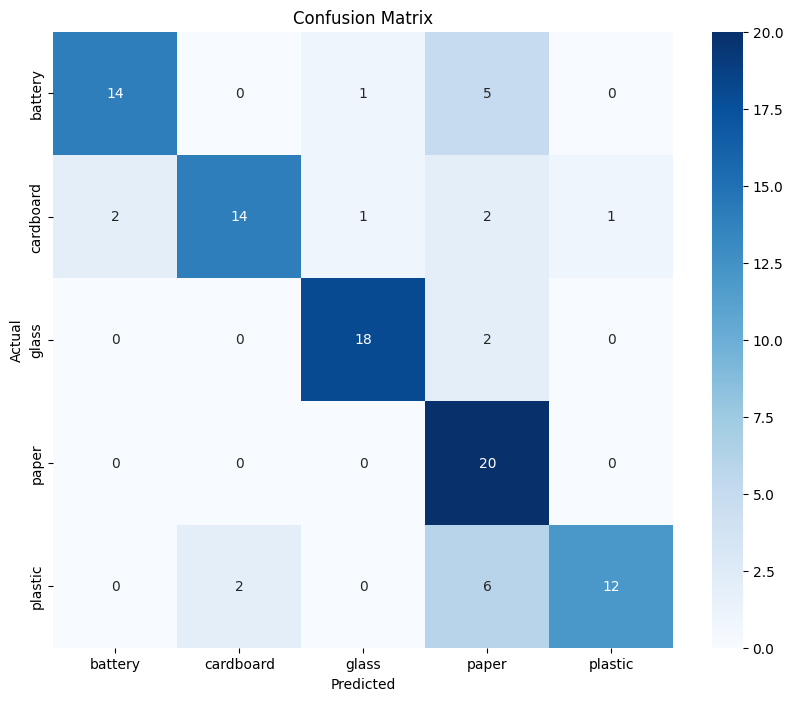

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Función para calcular la matriz de confusión
def compute_confusion_matrix(model, dataloader, device, num_classes):
    model.eval()  # Poner el modelo en modo evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover datos al dispositivo (CPU o GPU)
            images, labels = images.to(device), labels.to(device)

            # Predicciones
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Obtener las clases con mayor probabilidad

            # Guardar predicciones y etiquetas
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return cm

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)  # Mover el modelo al dispositivo

test_loader = valid_loader  # Reemplázalo con tu DataLoader de  validacion o testeo

# Define los nombres de las clases y su número
class_names = valid_loader.dataset.classes 
num_classes = len(valid_loader.dataset.classes)

# Calcular y visualizar la matriz de confusión
cm = compute_confusion_matrix(model, test_loader, device, num_classes)
plot_confusion_matrix(cm, class_names)

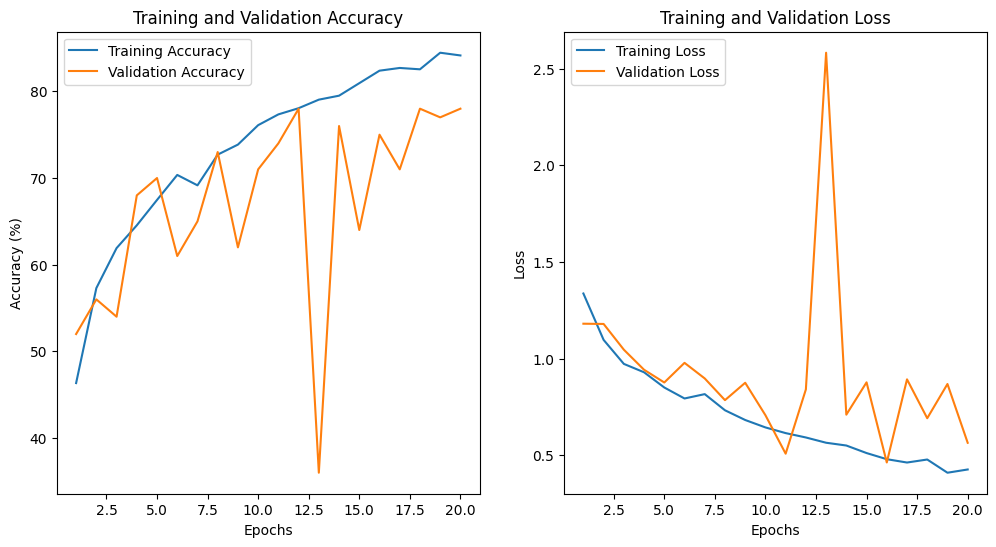

In [11]:
# Graficar Accuracy y Loss
epochs = range(1, num_epochs+1)

# Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()